In [1]:
# =======
# imports
# =======
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
import sqlite3
from itertools import chain
from matplotlib import rc
import matplotlib.image as mplimg
import shapely as shp
import gdal
import os

In [2]:
# read efretep map
gisdir = "C:\\Users\\dallalongaf\\OneDrive - TNO\\work\\2016 02 - TransRisk\\4 - energy access\\AFR\\gis_layers\\"
afr_countries = gpd.read_file(gisdir+"afretep_etrs_countries.shp")
afr_countries.head()

,ID,CODE,COUNTRY,CNTRY,REGION,countrycou,countrysum,countrymea,geometry
0,1,ALG,Algeria,Algeria,North Africa,2325210.0,407605757.0,175.298471,"POLYGON ((1894589.42156076 6093196.823427028, ..."
1,2,ANG,Angola,Angola,Central Africa,1247523.0,248776781.0,199.416589,"POLYGON ((3809405.5247603 2283690.127493567, 3..."
2,3,ANG,Angola,Angola,Central Africa,7152.0,1699358.0,237.605984,"POLYGON ((3744504.513407562 2674551.841173306,..."
3,4,ANG,Angola,Angola,Central Africa,102.0,21784.0,213.568627,"POLYGON ((3650051.721446254 1343900.192709396,..."
4,5,ANG,Angola,Angola,Central Africa,21.0,4608.0,219.428571,"POLYGON ((3755607.506678306 2543061.0734161, 3..."


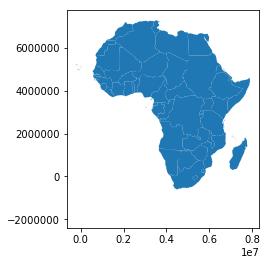

In [3]:
afr_countries.plot()

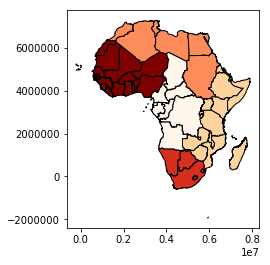

In [4]:
afr_countries.plot(column='REGION', cmap = 'OrRd', edgecolor='k')

In [5]:
afr_countries.crs

{u'a': 6378137,
 u'b': 6378137,
 u'lat_0': 0,
 u'lon_0': 18,
 u'no_defs': True,
 u'proj': u'laea',
 u'units': u'm',
 u'x_0': 4321000,
 u'y_0': 3210000}

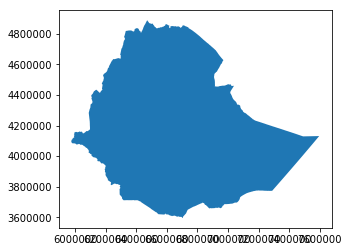

In [6]:
# ETH
eth_borders = afr_countries[afr_countries.CODE == 'ETH']
eth_borders.plot()

In [8]:
# gridlines map
grid = gpd.read_file(gisdir+"afretep_etrs_transmission.shp")
grid.tail()

,COUNTRY,FROM_NM,TO_NM,STATUS,SOURCES,PROJECT_NM,CNTRY,CLASS,VOLT,geometry
9505,NAM,None,None,None,None,None,Namibia,high,220,LINESTRING (4363778.734620872 73958.1340381186...
9506,NAM,None,None,None,None,None,Namibia,medium,22,LINESTRING (4282697.821641998 47479.7683415776...
9507,NAM,None,None,None,None,None,Namibia,medium,22,LINESTRING (4287038.181834367 52798.7137353341...
9508,NAM,None,None,None,None,None,Namibia,medium,66,LINESTRING (4363778.734620872 73958.1340381186...
9509,NAM,None,None,None,None,None,Namibia,medium,66,LINESTRING (4287038.181834367 52798.7137353341...


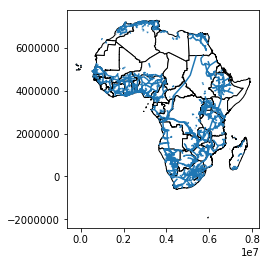

In [9]:
base = afr_countries.plot(color='white', edgecolor='black')
grid.plot(ax=base)

In [10]:
grid.COUNTRY.unique()

array([None, u'ZMB', u'TZA', u'SDN', u'LSO', u'NGA', u'UGA', u'MOZ',
       u'SEN', u'MRT', u'MWI', u'NER', u'RWA', u'AGO', u'BEN', u'BFA',
       u'BWA', u'CAF', u'CIV', u'CMR', u'ZAR', u'COG', u'CPV', u'ETH',
       u'GAB', u'GHA', u'GIN', u'GNB', u'KEN', u'LBR', u'MDG', u'MLI',
       u'TGO', u'NAM'], dtype=object)

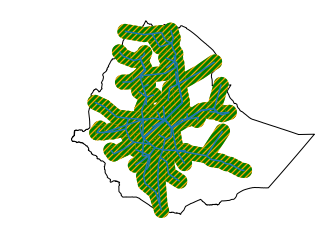

In [11]:
eth_grid = grid[grid.COUNTRY=='ETH']

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_axis_off()
eth_borders.plot(ax=ax, edgecolor='black', color='white')
eth_grid.plot(ax = ax)

plt.rcParams['hatch.color'] = 'green'
plt.rcParams['hatch.linewidth'] = 3
eth_grid.buffer(50000).plot(ax = ax, color = 'orange', hatch = '////')

In [12]:
# clip the borders off
# first turn buffer into geoDF
eth_grid_buff = gpd.GeoDataFrame(geometry = [eth_grid.buffer(50000).unary_union]) 
# with unary_union we collapse all segments into a single polygon

eth_grid_buff

,geometry
0,"POLYGON ((6951092.224880952 4002783.551181756,..."


C:\Users\dallalongaf\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\geopandas\base.py:75: UserWarning: Cannot generate spatial index: Missing package `rtree`.
  warn("Cannot generate spatial index: Missing package `rtree`.")


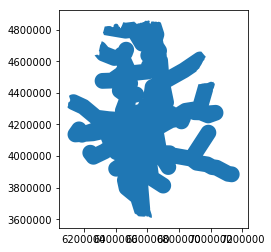

In [13]:
# use intersection to clip
# this would be very time-consuming if we don't use unary_union in teh step above
test = gpd.overlay(eth_borders, eth_grid_buff, how='intersection')
test.plot()

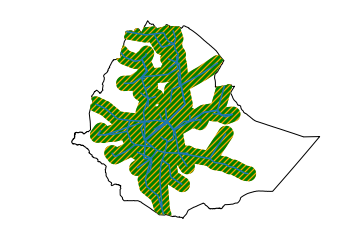

In [14]:
# plot again

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_axis_off()

eth_borders.plot(ax=ax, edgecolor='black', color='white')
eth_grid.plot(ax = ax)

test.plot(ax = ax, color = 'orange', hatch = '////')

In [7]:
# RASTER STUFF

afr_pop = gdal.Open(gisdir+"pp_afr.TIF")
pop_band = afr_pop.GetRasterBand(1)
pop_array = afr_pop.ReadAsArray()
pop_df = pd.DataFrame(pop_array)
pop_df = pop_df.replace(afr_pop.GetRasterBand(1).GetNoDataValue(), 0)

In [8]:
#plt.imshow(pop_array)

In [9]:
#Xgeo = GT(0) + Xpixel*GT(1) + Yline*GT(2)
#Ygeo = GT(3) + Xpixel*GT(4) + Yline*GT(5)
GT = afr_pop.GetGeoTransform()
def px2world(pt):
    xgeo = GT[0] + pt[0]*GT[1] + pt[1]*GT[2]
    ygeo = GT[3] + pt[0]*GT[4] + pt[1]*GT[5]
    return (xgeo,ygeo)

def px2world_shp(pt):
    xgeo = GT[0] + pt[0]*GT[1] + pt[1]*GT[2]
    ygeo = GT[3] + pt[0]*GT[4] + pt[1]*GT[5]
    return shp.geometry.Point(xgeo,ygeo)

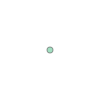

In [10]:
px2world_shp((0,0))

In [11]:
rows = np.array(pop_df.index)
cols = np.array(pop_df.columns)

In [37]:
# NOT EFFICIENT!!
# ---------------

test_df = pd.DataFrame(index = rows[:5], columns = cols[:3])
test_df.head()

,0,1,2
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN


In [54]:
test = pd.DataFrame([[(r,c) for c in cols] for r in rows])
test.head()

,0,1,2,3,4,5,6,7,8,9,...,8848,8849,8850,8851,8852,8853,8854,8855,8856,8857
0,"(0, 0)","(0, 1)","(0, 2)","(0, 3)","(0, 4)","(0, 5)","(0, 6)","(0, 7)","(0, 8)","(0, 9)",...,"(0, 8848)","(0, 8849)","(0, 8850)","(0, 8851)","(0, 8852)","(0, 8853)","(0, 8854)","(0, 8855)","(0, 8856)","(0, 8857)"
1,"(1, 0)","(1, 1)","(1, 2)","(1, 3)","(1, 4)","(1, 5)","(1, 6)","(1, 7)","(1, 8)","(1, 9)",...,"(1, 8848)","(1, 8849)","(1, 8850)","(1, 8851)","(1, 8852)","(1, 8853)","(1, 8854)","(1, 8855)","(1, 8856)","(1, 8857)"
2,"(2, 0)","(2, 1)","(2, 2)","(2, 3)","(2, 4)","(2, 5)","(2, 6)","(2, 7)","(2, 8)","(2, 9)",...,"(2, 8848)","(2, 8849)","(2, 8850)","(2, 8851)","(2, 8852)","(2, 8853)","(2, 8854)","(2, 8855)","(2, 8856)","(2, 8857)"
3,"(3, 0)","(3, 1)","(3, 2)","(3, 3)","(3, 4)","(3, 5)","(3, 6)","(3, 7)","(3, 8)","(3, 9)",...,"(3, 8848)","(3, 8849)","(3, 8850)","(3, 8851)","(3, 8852)","(3, 8853)","(3, 8854)","(3, 8855)","(3, 8856)","(3, 8857)"
4,"(4, 0)","(4, 1)","(4, 2)","(4, 3)","(4, 4)","(4, 5)","(4, 6)","(4, 7)","(4, 8)","(4, 9)",...,"(4, 8848)","(4, 8849)","(4, 8850)","(4, 8851)","(4, 8852)","(4, 8853)","(4, 8854)","(4, 8855)","(4, 8856)","(4, 8857)"


In [66]:
# takes about 1/2 hour!!!! 
test2 = pd.DataFrame(index = rows, columns = cols)
for c in test2.columns:
    test2.loc[:,c] = test.loc[:,c].apply(px2world)
test2.head()

,0,1,2,3,4,5,6,7,8,9,...,8848,8849,8850,8851,8852,8853,8854,8855,8856,8857
0,"(-17.5352363586, 37.546068573)","(-17.5352363586, 37.5377352397)","(-17.5352363586, 37.5294019063)","(-17.5352363586, 37.521068573)","(-17.5352363586, 37.5127352397)","(-17.5352363586, 37.5044019063)","(-17.5352363586, 37.496068573)","(-17.5352363586, 37.4877352397)","(-17.5352363586, 37.4794019063)","(-17.5352363586, 37.471068573)",...,"(-17.5352363586, -36.1872647603)","(-17.5352363586, -36.1955980937)","(-17.5352363586, -36.203931427)","(-17.5352363586, -36.2122647603)","(-17.5352363586, -36.2205980937)","(-17.5352363586, -36.228931427)","(-17.5352363586, -36.2372647603)","(-17.5352363586, -36.2455980937)","(-17.5352363586, -36.253931427)","(-17.5352363586, -36.2622647603)"
1,"(-17.5269030253, 37.546068573)","(-17.5269030253, 37.5377352397)","(-17.5269030253, 37.5294019063)","(-17.5269030253, 37.521068573)","(-17.5269030253, 37.5127352397)","(-17.5269030253, 37.5044019063)","(-17.5269030253, 37.496068573)","(-17.5269030253, 37.4877352397)","(-17.5269030253, 37.4794019063)","(-17.5269030253, 37.471068573)",...,"(-17.5269030253, -36.1872647603)","(-17.5269030253, -36.1955980937)","(-17.5269030253, -36.203931427)","(-17.5269030253, -36.2122647603)","(-17.5269030253, -36.2205980937)","(-17.5269030253, -36.228931427)","(-17.5269030253, -36.2372647603)","(-17.5269030253, -36.2455980937)","(-17.5269030253, -36.253931427)","(-17.5269030253, -36.2622647603)"
2,"(-17.518569692, 37.546068573)","(-17.518569692, 37.5377352397)","(-17.518569692, 37.5294019063)","(-17.518569692, 37.521068573)","(-17.518569692, 37.5127352397)","(-17.518569692, 37.5044019063)","(-17.518569692, 37.496068573)","(-17.518569692, 37.4877352397)","(-17.518569692, 37.4794019063)","(-17.518569692, 37.471068573)",...,"(-17.518569692, -36.1872647603)","(-17.518569692, -36.1955980937)","(-17.518569692, -36.203931427)","(-17.518569692, -36.2122647603)","(-17.518569692, -36.2205980937)","(-17.518569692, -36.228931427)","(-17.518569692, -36.2372647603)","(-17.518569692, -36.2455980937)","(-17.518569692, -36.253931427)","(-17.518569692, -36.2622647603)"
3,"(-17.5102363586, 37.546068573)","(-17.5102363586, 37.5377352397)","(-17.5102363586, 37.5294019063)","(-17.5102363586, 37.521068573)","(-17.5102363586, 37.5127352397)","(-17.5102363586, 37.5044019063)","(-17.5102363586, 37.496068573)","(-17.5102363586, 37.4877352397)","(-17.5102363586, 37.4794019063)","(-17.5102363586, 37.471068573)",...,"(-17.5102363586, -36.1872647603)","(-17.5102363586, -36.1955980937)","(-17.5102363586, -36.203931427)","(-17.5102363586, -36.2122647603)","(-17.5102363586, -36.2205980937)","(-17.5102363586, -36.228931427)","(-17.5102363586, -36.2372647603)","(-17.5102363586, -36.2455980937)","(-17.5102363586, -36.253931427)","(-17.5102363586, -36.2622647603)"
4,"(-17.5019030253, 37.546068573)","(-17.5019030253, 37.5377352397)","(-17.5019030253, 37.5294019063)","(-17.5019030253, 37.521068573)","(-17.5019030253, 37.5127352397)","(-17.5019030253, 37.5044019063)","(-17.5019030253, 37.496068573)","(-17.5019030253, 37.4877352397)","(-17.5019030253, 37.4794019063)","(-17.5019030253, 37.471068573)",...,"(-17.5019030253, -36.1872647603)","(-17.5019030253, -36.1955980937)","(-17.5019030253, -36.203931427)","(-17.5019030253, -36.2122647603)","(-17.5019030253, -36.2205980937)","(-17.5019030253, -36.228931427)","(-17.5019030253, -36.2372647603)","(-17.5019030253, -36.2455980937)","(-17.5019030253, -36.253931427)","(-17.5019030253, -36.2622647603)"


In [68]:
import datetime
now = datetime.datetime.now()
for c in test2.columns[:1]:
    test2.loc[:,c] = test.loc[:,c].apply(px2world)
then = datetime.datetime.now()
print (then-now)*len(test2.columns)

0:41:29.098000


In [69]:
test2.head()

,0,1,2,3,4,5,6,7,8,9,...,8848,8849,8850,8851,8852,8853,8854,8855,8856,8857
0,"(-17.5352363586, 37.546068573)","(-17.5352363586, 37.5377352397)","(-17.5352363586, 37.5294019063)","(-17.5352363586, 37.521068573)","(-17.5352363586, 37.5127352397)","(-17.5352363586, 37.5044019063)","(-17.5352363586, 37.496068573)","(-17.5352363586, 37.4877352397)","(-17.5352363586, 37.4794019063)","(-17.5352363586, 37.471068573)",...,"(-17.5352363586, -36.1872647603)","(-17.5352363586, -36.1955980937)","(-17.5352363586, -36.203931427)","(-17.5352363586, -36.2122647603)","(-17.5352363586, -36.2205980937)","(-17.5352363586, -36.228931427)","(-17.5352363586, -36.2372647603)","(-17.5352363586, -36.2455980937)","(-17.5352363586, -36.253931427)","(-17.5352363586, -36.2622647603)"
1,"(-17.5269030253, 37.546068573)","(-17.5269030253, 37.5377352397)","(-17.5269030253, 37.5294019063)","(-17.5269030253, 37.521068573)","(-17.5269030253, 37.5127352397)","(-17.5269030253, 37.5044019063)","(-17.5269030253, 37.496068573)","(-17.5269030253, 37.4877352397)","(-17.5269030253, 37.4794019063)","(-17.5269030253, 37.471068573)",...,"(-17.5269030253, -36.1872647603)","(-17.5269030253, -36.1955980937)","(-17.5269030253, -36.203931427)","(-17.5269030253, -36.2122647603)","(-17.5269030253, -36.2205980937)","(-17.5269030253, -36.228931427)","(-17.5269030253, -36.2372647603)","(-17.5269030253, -36.2455980937)","(-17.5269030253, -36.253931427)","(-17.5269030253, -36.2622647603)"
2,"(-17.518569692, 37.546068573)","(-17.518569692, 37.5377352397)","(-17.518569692, 37.5294019063)","(-17.518569692, 37.521068573)","(-17.518569692, 37.5127352397)","(-17.518569692, 37.5044019063)","(-17.518569692, 37.496068573)","(-17.518569692, 37.4877352397)","(-17.518569692, 37.4794019063)","(-17.518569692, 37.471068573)",...,"(-17.518569692, -36.1872647603)","(-17.518569692, -36.1955980937)","(-17.518569692, -36.203931427)","(-17.518569692, -36.2122647603)","(-17.518569692, -36.2205980937)","(-17.518569692, -36.228931427)","(-17.518569692, -36.2372647603)","(-17.518569692, -36.2455980937)","(-17.518569692, -36.253931427)","(-17.518569692, -36.2622647603)"
3,"(-17.5102363586, 37.546068573)","(-17.5102363586, 37.5377352397)","(-17.5102363586, 37.5294019063)","(-17.5102363586, 37.521068573)","(-17.5102363586, 37.5127352397)","(-17.5102363586, 37.5044019063)","(-17.5102363586, 37.496068573)","(-17.5102363586, 37.4877352397)","(-17.5102363586, 37.4794019063)","(-17.5102363586, 37.471068573)",...,"(-17.5102363586, -36.1872647603)","(-17.5102363586, -36.1955980937)","(-17.5102363586, -36.203931427)","(-17.5102363586, -36.2122647603)","(-17.5102363586, -36.2205980937)","(-17.5102363586, -36.228931427)","(-17.5102363586, -36.2372647603)","(-17.5102363586, -36.2455980937)","(-17.5102363586, -36.253931427)","(-17.5102363586, -36.2622647603)"
4,"(-17.5019030253, 37.546068573)","(-17.5019030253, 37.5377352397)","(-17.5019030253, 37.5294019063)","(-17.5019030253, 37.521068573)","(-17.5019030253, 37.5127352397)","(-17.5019030253, 37.5044019063)","(-17.5019030253, 37.496068573)","(-17.5019030253, 37.4877352397)","(-17.5019030253, 37.4794019063)","(-17.5019030253, 37.471068573)",...,"(-17.5019030253, -36.1872647603)","(-17.5019030253, -36.1955980937)","(-17.5019030253, -36.203931427)","(-17.5019030253, -36.2122647603)","(-17.5019030253, -36.2205980937)","(-17.5019030253, -36.228931427)","(-17.5019030253, -36.2372647603)","(-17.5019030253, -36.2455980937)","(-17.5019030253, -36.253931427)","(-17.5019030253, -36.2622647603)"


In [73]:
test2.to_csv("afr_pop_latlong.csv")

In [12]:
# MORE EFFICIENT WAY:
# -------------------

# all x pixels

xarray = pd.DataFrame([r]*len(cols) for r in rows)
xarray.head()

,0,1,2,3,4,5,6,7,8,9,...,8848,8849,8850,8851,8852,8853,8854,8855,8856,8857
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
3,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
4,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4


In [13]:
# all y pixels

yarray = pd.DataFrame([c]*len(rows) for c in cols).transpose()
yarray.head()

,0,1,2,3,4,5,6,7,8,9,...,8848,8849,8850,8851,8852,8853,8854,8855,8856,8857
0,0,1,2,3,4,5,6,7,8,9,...,8848,8849,8850,8851,8852,8853,8854,8855,8856,8857
1,0,1,2,3,4,5,6,7,8,9,...,8848,8849,8850,8851,8852,8853,8854,8855,8856,8857
2,0,1,2,3,4,5,6,7,8,9,...,8848,8849,8850,8851,8852,8853,8854,8855,8856,8857
3,0,1,2,3,4,5,6,7,8,9,...,8848,8849,8850,8851,8852,8853,8854,8855,8856,8857
4,0,1,2,3,4,5,6,7,8,9,...,8848,8849,8850,8851,8852,8853,8854,8855,8856,8857


In [11]:
#xyarray = pd.DataFrame([[(r,c) for c in cols] for r in rows])
#xyarray.head()

,0,1,2,3,4,5,6,7,8,9,...,8848,8849,8850,8851,8852,8853,8854,8855,8856,8857
0,"(0, 0)","(0, 1)","(0, 2)","(0, 3)","(0, 4)","(0, 5)","(0, 6)","(0, 7)","(0, 8)","(0, 9)",...,"(0, 8848)","(0, 8849)","(0, 8850)","(0, 8851)","(0, 8852)","(0, 8853)","(0, 8854)","(0, 8855)","(0, 8856)","(0, 8857)"
1,"(1, 0)","(1, 1)","(1, 2)","(1, 3)","(1, 4)","(1, 5)","(1, 6)","(1, 7)","(1, 8)","(1, 9)",...,"(1, 8848)","(1, 8849)","(1, 8850)","(1, 8851)","(1, 8852)","(1, 8853)","(1, 8854)","(1, 8855)","(1, 8856)","(1, 8857)"
2,"(2, 0)","(2, 1)","(2, 2)","(2, 3)","(2, 4)","(2, 5)","(2, 6)","(2, 7)","(2, 8)","(2, 9)",...,"(2, 8848)","(2, 8849)","(2, 8850)","(2, 8851)","(2, 8852)","(2, 8853)","(2, 8854)","(2, 8855)","(2, 8856)","(2, 8857)"
3,"(3, 0)","(3, 1)","(3, 2)","(3, 3)","(3, 4)","(3, 5)","(3, 6)","(3, 7)","(3, 8)","(3, 9)",...,"(3, 8848)","(3, 8849)","(3, 8850)","(3, 8851)","(3, 8852)","(3, 8853)","(3, 8854)","(3, 8855)","(3, 8856)","(3, 8857)"
4,"(4, 0)","(4, 1)","(4, 2)","(4, 3)","(4, 4)","(4, 5)","(4, 6)","(4, 7)","(4, 8)","(4, 9)",...,"(4, 8848)","(4, 8849)","(4, 8850)","(4, 8851)","(4, 8852)","(4, 8853)","(4, 8854)","(4, 8855)","(4, 8856)","(4, 8857)"


In [17]:
# make two dfs with lat and long
pop_latlong = px2world((xarray,yarray))

pop_x_df = pd.DataFrame(pop_latlong[0])
pop_y_df = pd.DataFrame(pop_latlong[1])

pop_x_df.head()

,0,1,2,3,4,5,6,7,8,9,...,8848,8849,8850,8851,8852,8853,8854,8855,8856,8857
0,-17.535236,-17.535236,-17.535236,-17.535236,-17.535236,-17.535236,-17.535236,-17.535236,-17.535236,-17.535236,...,-17.535236,-17.535236,-17.535236,-17.535236,-17.535236,-17.535236,-17.535236,-17.535236,-17.535236,-17.535236
1,-17.526903,-17.526903,-17.526903,-17.526903,-17.526903,-17.526903,-17.526903,-17.526903,-17.526903,-17.526903,...,-17.526903,-17.526903,-17.526903,-17.526903,-17.526903,-17.526903,-17.526903,-17.526903,-17.526903,-17.526903
2,-17.518570,-17.518570,-17.518570,-17.518570,-17.518570,-17.518570,-17.518570,-17.518570,-17.518570,-17.518570,...,-17.518570,-17.518570,-17.518570,-17.518570,-17.518570,-17.518570,-17.518570,-17.518570,-17.518570,-17.518570
3,-17.510236,-17.510236,-17.510236,-17.510236,-17.510236,-17.510236,-17.510236,-17.510236,-17.510236,-17.510236,...,-17.510236,-17.510236,-17.510236,-17.510236,-17.510236,-17.510236,-17.510236,-17.510236,-17.510236,-17.510236
4,-17.501903,-17.501903,-17.501903,-17.501903,-17.501903,-17.501903,-17.501903,-17.501903,-17.501903,-17.501903,...,-17.501903,-17.501903,-17.501903,-17.501903,-17.501903,-17.501903,-17.501903,-17.501903,-17.501903,-17.501903


In [18]:
pop_y_df.head()

,0,1,2,3,4,5,6,7,8,9,...,8848,8849,8850,8851,8852,8853,8854,8855,8856,8857
0,37.546069,37.537735,37.529402,37.521069,37.512735,37.504402,37.496069,37.487735,37.479402,37.471069,...,-36.187265,-36.195598,-36.203931,-36.212265,-36.220598,-36.228931,-36.237265,-36.245598,-36.253931,-36.262265
1,37.546069,37.537735,37.529402,37.521069,37.512735,37.504402,37.496069,37.487735,37.479402,37.471069,...,-36.187265,-36.195598,-36.203931,-36.212265,-36.220598,-36.228931,-36.237265,-36.245598,-36.253931,-36.262265
2,37.546069,37.537735,37.529402,37.521069,37.512735,37.504402,37.496069,37.487735,37.479402,37.471069,...,-36.187265,-36.195598,-36.203931,-36.212265,-36.220598,-36.228931,-36.237265,-36.245598,-36.253931,-36.262265
3,37.546069,37.537735,37.529402,37.521069,37.512735,37.504402,37.496069,37.487735,37.479402,37.471069,...,-36.187265,-36.195598,-36.203931,-36.212265,-36.220598,-36.228931,-36.237265,-36.245598,-36.253931,-36.262265
4,37.546069,37.537735,37.529402,37.521069,37.512735,37.504402,37.496069,37.487735,37.479402,37.471069,...,-36.187265,-36.195598,-36.203931,-36.212265,-36.220598,-36.228931,-36.237265,-36.245598,-36.253931,-36.262265


In [19]:
import datetime
now = datetime.datetime.now()
pop_xy_df = pd.DataFrame(np.rec.fromarrays((pop_x_df.values, pop_y_df.values)).tolist(), 
                      columns=xarray.columns,
                      index=xarray.index)
then = datetime.datetime.now()
print then-now

0:00:46.016000


In [20]:
pop_xy_df.head()

,0,1,2,3,4,5,6,7,8,9,...,8848,8849,8850,8851,8852,8853,8854,8855,8856,8857
0,"(-17.5352363586, 37.546068573)","(-17.5352363586, 37.5377352397)","(-17.5352363586, 37.5294019063)","(-17.5352363586, 37.521068573)","(-17.5352363586, 37.5127352397)","(-17.5352363586, 37.5044019063)","(-17.5352363586, 37.496068573)","(-17.5352363586, 37.4877352397)","(-17.5352363586, 37.4794019063)","(-17.5352363586, 37.471068573)",...,"(-17.5352363586, -36.1872647603)","(-17.5352363586, -36.1955980937)","(-17.5352363586, -36.203931427)","(-17.5352363586, -36.2122647603)","(-17.5352363586, -36.2205980937)","(-17.5352363586, -36.228931427)","(-17.5352363586, -36.2372647603)","(-17.5352363586, -36.2455980937)","(-17.5352363586, -36.253931427)","(-17.5352363586, -36.2622647603)"
1,"(-17.5269030253, 37.546068573)","(-17.5269030253, 37.5377352397)","(-17.5269030253, 37.5294019063)","(-17.5269030253, 37.521068573)","(-17.5269030253, 37.5127352397)","(-17.5269030253, 37.5044019063)","(-17.5269030253, 37.496068573)","(-17.5269030253, 37.4877352397)","(-17.5269030253, 37.4794019063)","(-17.5269030253, 37.471068573)",...,"(-17.5269030253, -36.1872647603)","(-17.5269030253, -36.1955980937)","(-17.5269030253, -36.203931427)","(-17.5269030253, -36.2122647603)","(-17.5269030253, -36.2205980937)","(-17.5269030253, -36.228931427)","(-17.5269030253, -36.2372647603)","(-17.5269030253, -36.2455980937)","(-17.5269030253, -36.253931427)","(-17.5269030253, -36.2622647603)"
2,"(-17.518569692, 37.546068573)","(-17.518569692, 37.5377352397)","(-17.518569692, 37.5294019063)","(-17.518569692, 37.521068573)","(-17.518569692, 37.5127352397)","(-17.518569692, 37.5044019063)","(-17.518569692, 37.496068573)","(-17.518569692, 37.4877352397)","(-17.518569692, 37.4794019063)","(-17.518569692, 37.471068573)",...,"(-17.518569692, -36.1872647603)","(-17.518569692, -36.1955980937)","(-17.518569692, -36.203931427)","(-17.518569692, -36.2122647603)","(-17.518569692, -36.2205980937)","(-17.518569692, -36.228931427)","(-17.518569692, -36.2372647603)","(-17.518569692, -36.2455980937)","(-17.518569692, -36.253931427)","(-17.518569692, -36.2622647603)"
3,"(-17.5102363586, 37.546068573)","(-17.5102363586, 37.5377352397)","(-17.5102363586, 37.5294019063)","(-17.5102363586, 37.521068573)","(-17.5102363586, 37.5127352397)","(-17.5102363586, 37.5044019063)","(-17.5102363586, 37.496068573)","(-17.5102363586, 37.4877352397)","(-17.5102363586, 37.4794019063)","(-17.5102363586, 37.471068573)",...,"(-17.5102363586, -36.1872647603)","(-17.5102363586, -36.1955980937)","(-17.5102363586, -36.203931427)","(-17.5102363586, -36.2122647603)","(-17.5102363586, -36.2205980937)","(-17.5102363586, -36.228931427)","(-17.5102363586, -36.2372647603)","(-17.5102363586, -36.2455980937)","(-17.5102363586, -36.253931427)","(-17.5102363586, -36.2622647603)"
4,"(-17.5019030253, 37.546068573)","(-17.5019030253, 37.5377352397)","(-17.5019030253, 37.5294019063)","(-17.5019030253, 37.521068573)","(-17.5019030253, 37.5127352397)","(-17.5019030253, 37.5044019063)","(-17.5019030253, 37.496068573)","(-17.5019030253, 37.4877352397)","(-17.5019030253, 37.4794019063)","(-17.5019030253, 37.471068573)",...,"(-17.5019030253, -36.1872647603)","(-17.5019030253, -36.1955980937)","(-17.5019030253, -36.203931427)","(-17.5019030253, -36.2122647603)","(-17.5019030253, -36.2205980937)","(-17.5019030253, -36.228931427)","(-17.5019030253, -36.2372647603)","(-17.5019030253, -36.2455980937)","(-17.5019030253, -36.253931427)","(-17.5019030253, -36.2622647603)"


In [15]:
from shapely import speedups
speedups.enable()

In [21]:
eth = eth_borders.to_crs({'init' :'epsg:4326'})

In [22]:
eth.bounds #.minx.values[0]

,minx,miny,maxx,maxy
311,32.99994,3.402422,47.98618,14.89996


In [23]:
eth_bounds_x = pop_x_df[(pop_x_df>=eth.bounds.minx.values[0]) & (pop_x_df<=eth.bounds.maxx.values[0])]
eth_bounds_x.head()

,0,1,2,3,4,5,6,7,8,9,...,8848,8849,8850,8851,8852,8853,8854,8855,8856,8857
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
eth_bounds_x = eth_bounds_x.dropna(how='all')
eth_bounds_x.head()

,0,1,2,3,4,5,6,7,8,9,...,8848,8849,8850,8851,8852,8853,8854,8855,8856,8857
6065,33.006430,33.006430,33.006430,33.006430,33.006430,33.006430,33.006430,33.006430,33.006430,33.006430,...,33.006430,33.006430,33.006430,33.006430,33.006430,33.006430,33.006430,33.006430,33.006430,33.006430
6066,33.014764,33.014764,33.014764,33.014764,33.014764,33.014764,33.014764,33.014764,33.014764,33.014764,...,33.014764,33.014764,33.014764,33.014764,33.014764,33.014764,33.014764,33.014764,33.014764,33.014764
6067,33.023097,33.023097,33.023097,33.023097,33.023097,33.023097,33.023097,33.023097,33.023097,33.023097,...,33.023097,33.023097,33.023097,33.023097,33.023097,33.023097,33.023097,33.023097,33.023097,33.023097
6068,33.031430,33.031430,33.031430,33.031430,33.031430,33.031430,33.031430,33.031430,33.031430,33.031430,...,33.031430,33.031430,33.031430,33.031430,33.031430,33.031430,33.031430,33.031430,33.031430,33.031430
6069,33.039764,33.039764,33.039764,33.039764,33.039764,33.039764,33.039764,33.039764,33.039764,33.039764,...,33.039764,33.039764,33.039764,33.039764,33.039764,33.039764,33.039764,33.039764,33.039764,33.039764


In [25]:
eth_bounds_y = pop_y_df[(pop_y_df>=eth.bounds.miny.values[0]) & (pop_y_df<=eth.bounds.maxy.values[0])]
eth_bounds_y = eth_bounds_y.dropna(how='all', axis=1)
eth_bounds_y.head()

,2718,2719,2720,2721,2722,2723,2724,2725,2726,2727,...,4088,4089,4090,4091,4092,4093,4094,4095,4096,4097
0,14.896069,14.887735,14.879402,14.871069,14.862735,14.854402,14.846069,14.837735,14.829402,14.821069,...,3.479402,3.471069,3.462735,3.454402,3.446069,3.437735,3.429402,3.421069,3.412735,3.404402
1,14.896069,14.887735,14.879402,14.871069,14.862735,14.854402,14.846069,14.837735,14.829402,14.821069,...,3.479402,3.471069,3.462735,3.454402,3.446069,3.437735,3.429402,3.421069,3.412735,3.404402
2,14.896069,14.887735,14.879402,14.871069,14.862735,14.854402,14.846069,14.837735,14.829402,14.821069,...,3.479402,3.471069,3.462735,3.454402,3.446069,3.437735,3.429402,3.421069,3.412735,3.404402
3,14.896069,14.887735,14.879402,14.871069,14.862735,14.854402,14.846069,14.837735,14.829402,14.821069,...,3.479402,3.471069,3.462735,3.454402,3.446069,3.437735,3.429402,3.421069,3.412735,3.404402
4,14.896069,14.887735,14.879402,14.871069,14.862735,14.854402,14.846069,14.837735,14.829402,14.821069,...,3.479402,3.471069,3.462735,3.454402,3.446069,3.437735,3.429402,3.421069,3.412735,3.404402


In [115]:
eth_bounds_x.index

Int64Index([6065, 6066, 6067, 6068, 6069, 6070, 6071, 6072, 6073, 6074,
            ...
            7853, 7854, 7855, 7856, 7857, 7858, 7859, 7860, 7861, 7862],
           dtype='int64', length=1798)

In [116]:
eth_bounds_y.columns

Int64Index([2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727,
            ...
            4088, 4089, 4090, 4091, 4092, 4093, 4094, 4095, 4096, 4097],
           dtype='int64', length=1380)

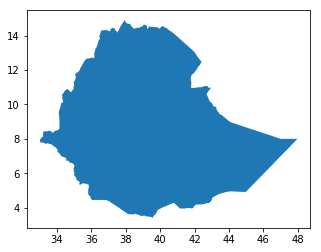

In [26]:
eth.plot()

In [31]:
pop_eth = pop_xy_df.loc[eth_bounds_x.index,eth_bounds_y.columns]
#plt.imshow(pop_eth.values)

In [40]:
start = datetime.datetime.now()
pts = []
for c in pop_eth.columns:
    pts.append(pop_eth.loc[:,c].apply(shp.geometry.Point))
stop = datetime.datetime.now()
print (stop-start)

0:00:47.766000


In [62]:
eth_df = gpd.GeoSeries(np.array(pts).flatten())
eth_df[:5]

0    POINT (33.00643030802404 14.89606857299797)
1    POINT (33.01476364135738 14.89606857299797)
2    POINT (33.02309697469071 14.89606857299797)
3    POINT (33.03143030802404 14.89606857299797)
4    POINT (33.03976364135738 14.89606857299797)
dtype: object

In [69]:
start= datetime.datetime.now()
eth_df[:10][eth.contains(eth_df[:10])]
stop = datetime.datetime.now()
print (stop-start)*len(eth_df)/10

1:10:18.108000


In [71]:
import gdalnumeric
pop_num = gdalnumeric.LoadFile(gisdir+"pp_afr.TIF")

In [ ]:
plt.imshow(pop_num)